In [68]:
import tensorflow as tf
import os
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler



### Import CSV and transform 

In [48]:
df = pd.read_csv("F:\Git\Food-price-forecast\ModelsAndDatasets\Datasets\price_temp_grain_starch.csv")
df = df.drop(columns=["Unnamed: 0"])   #Lösche unnötige Spalte
df.index = pd.to_datetime(df['Date'], format = '%Y-%m') #Datum als Index
df = df[df.Date <= "2021-12-01"]  #Alles vor 2022
df

,Date,Food_Price,Air_Temperature,grain_starch_output_price
Date,,,,
1996-01-01,1996-01,74.9,-2.82,87.3
1996-02-01,1996-02,75.5,-2.18,87.4
1996-03-01,1996-03,76.1,1.00,87.7
1996-04-01,1996-04,76.4,8.40,87.8
1996-05-01,1996-05,76.2,11.15,88.8
...,...,...,...,...
2021-08-01,2021-08,114.2,16.40,107.2
2021-09-01,2021-09,114.2,15.16,108.2
2021-10-01,2021-10,114.2,9.63,112.8


### Plot Food-Price

<Axes: xlabel='Date'>

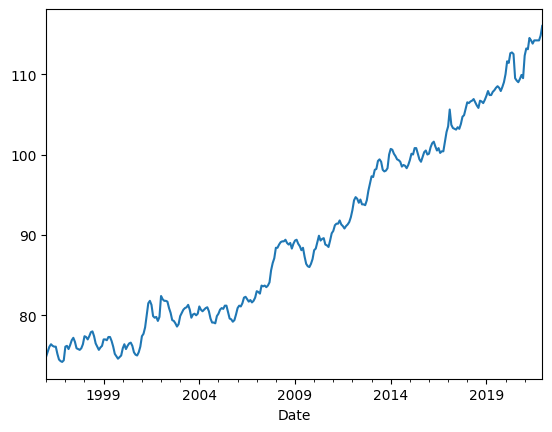

In [49]:
price = df["Food_Price"]
price.plot()


### Erstelle Sliding-Window Arrays

In [50]:
def df_to_X_y(df, window_size=5): #gebe DataFrame und Zeitraum der zu berücksichtigenden Perioden für Vorhersage an 
    df_as_np = df.to_numpy()
    X = [] # Vergangene Werte für Vorhersage
    y = [] # Labels für zu vorhersagende Periode

    for i in range(len(df_as_np)-window_size): #Iteration über numpy-Liste der Werte abzüglich window size
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)          #Gebe Zeitreihe für X und y zurück

#### Überprüfe Format 

In [51]:
window = 9
X, y = df_to_X_y(price, window)
X.shape, y.shape

((303, 9, 1), (303,))

#### Erstelle Test-Train Split

In [52]:
X_train, y_train = X[:250], y[:250]
X_val, y_val = X[250:275], y[250:275]
X_test, y_test = X[275:], y[275:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape  #Überprüfufe Form der Splits


((250, 9, 1), (250,), (25, 9, 1), (25,), (28, 9, 1), (28,))

## Model-Definition & Training

### Erstelle LSTM-Model with Tensorflow

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import * 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((window, 1)))
model1.add(LSTM(64))
model1.add(Dense(8,'relu'))
model1.add(Dense(1,'linear'))

model1.summary()


model2 = Sequential()
model2.add(LSTM(64, activation='relu', input_shape=(window, 1), return_sequences=True))
model2.add(LSTM(32, activation='relu', return_sequences=False))
model2.add(Dropout(0.1))
model2.add(Dense(1))

model2.compile(optimizer='adam', loss='mape')
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64)                16896     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 9, 64)             16896     
                                                              

### Anweisung, dass nur bestes Modell nach Training gespeichert werden soll

In [54]:
cp = ModelCheckpoint("model1/", save_best_only = True) #Speichere nur bestes Modell mit niedrigstem MeanSqúaredError
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

cp2 = ModelCheckpoint("model2/", save_best_only = True) #Speichere nur bestes Modell mit niedrigstem MeanSqúaredError
model2.compile(loss="mape", optimizer=Adam(learning_rate=0.001), metrics=["mape"])

### Model Training mit Training und Validation Dataset

In [ ]:
model1.fit(X_train,y_train,validation_data = (X_val,y_val), epochs=100,verbose = 1, callbacks=[cp])

In [ ]:
model2.fit(X_train, y_train, epochs=600, validation_data = (X_val,y_val), batch_size=32, verbose=1, callbacks=[cp2])

### Lade beste Modelle aus Training

In [57]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')
model2 = load_model('model2/')

## Vorhersage & Performance



Training-MAPE 1.3132350012422132
Validation-MAPE 0.6405313754838426
Test-MAPE 1.420551890316658


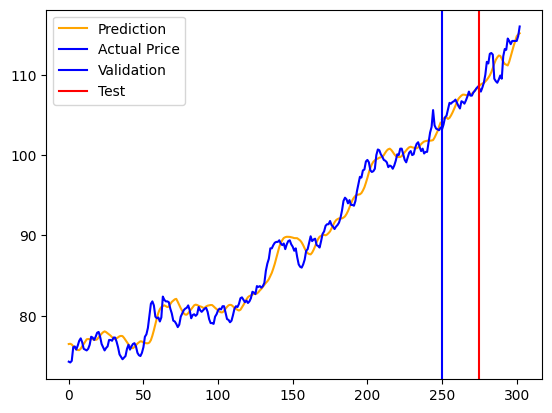

In [67]:
plt.plot(train_results['Train Predictions'],label='Prediction', color = "orange")
plt.plot(train_results['Actuals'],label='Actual Price', color = "b")
plt.plot(np.arange(len(val_results))+len(train_results),val_results['Validation Predictions'],color = 'orange')
plt.plot(np.arange(len(val_results))+len(train_results),val_results['Actuals'], color = "b")
plt.plot(np.arange(len(test_results))+len(train_results)+len(val_results),test_results['Test Predictions'], color = "orange")
plt.plot(np.arange(len(test_results))+len(train_results)+len(val_results),test_results['Actuals'],color = "b")
plt.axvline(x = 250, color = 'b', label = 'Validation')
plt.axvline(x = 275, color = 'r', label = 'Test')
plt.legend()
plt.legend()

print(f"Training-MAPE {tf.keras.metrics.mean_absolute_percentage_error(train_results['Train Predictions'],train_results['Actuals'])}")
print(f"Validation-MAPE {tf.keras.metrics.mean_absolute_percentage_error(val_results['Validation Predictions'],val_results['Actuals'])}")
print(f"Test-MAPE {tf.keras.metrics.mean_absolute_percentage_error(test_results['Test Predictions'],test_results['Actuals'])}")


### Training Data-Set isolierte Ansicht

In [58]:
train_predictions = model2.predict(X_train).flatten() #Preis-Vorhersagen des Trainingsets

#Dictionary mit Preis-Vorhersagen und tatsächlichen Preisen des Trainingsets
train_results = pd.DataFrame(data={'Train Predictions':train_predictions,'Actuals': y_train}) 
train_results

tf.keras.metrics.mean_absolute_percentage_error(train_results['Train Predictions'],train_results['Actuals'])  #Mean Absolute percentage Error

8/8 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(), dtype=float64, numpy=1.3132350012422132>

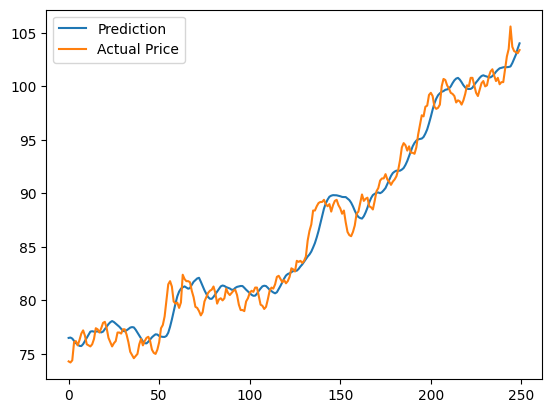

In [59]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'],label='Prediction')
plt.plot(train_results['Actuals'],label='Actual Price')
plt.legend()



### Validation Data-Set islolierte Ansicht

In [61]:
val_predictions = model2.predict(X_val).flatten() #Preis-Vorhersagen des Trainingsets

#Dictionary mit Preis-Vorhersagen und tatsächlichen Preisen des Trainingsets
val_results = pd.DataFrame(data={'Validation Predictions':val_predictions,'Actuals': y_val}) 
val_results

tf.keras.metrics.mean_absolute_percentage_error(val_results['Validation Predictions'],val_results['Actuals'])

1/1 [==============================] - 0s 21ms/step


<tf.Tensor: shape=(), dtype=float64, numpy=0.6405313754838426>

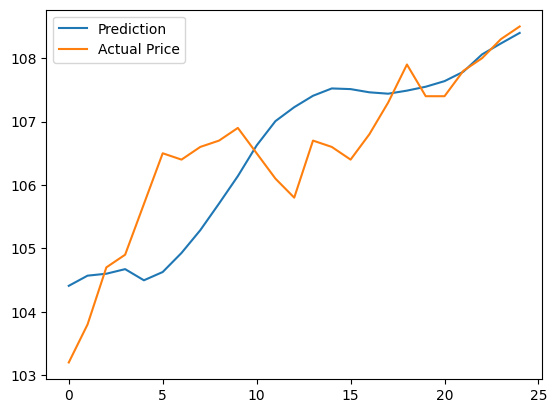

In [62]:
plt.plot(val_results['Validation Predictions'],label='Prediction')
plt.plot(val_results['Actuals'],label='Actual Price')
plt.legend()


### Test Data-Set isolierte Ansicht

In [65]:
test_predictions = model2.predict(X_test).flatten() #Preis-Vorhersagen des Trainingsets

#Dictionary mit Preis-Vorhersagen und tatsächlichen Preisen des Trainingsets
test_results = pd.DataFrame(data={'Test Predictions':test_predictions,'Actuals': y_test}) 
test_results

tf.keras.metrics.mean_absolute_percentage_error(test_results['Test Predictions'],test_results['Actuals'])

1/1 [==============================] - 0s 20ms/step


<tf.Tensor: shape=(), dtype=float64, numpy=1.420551890316658>

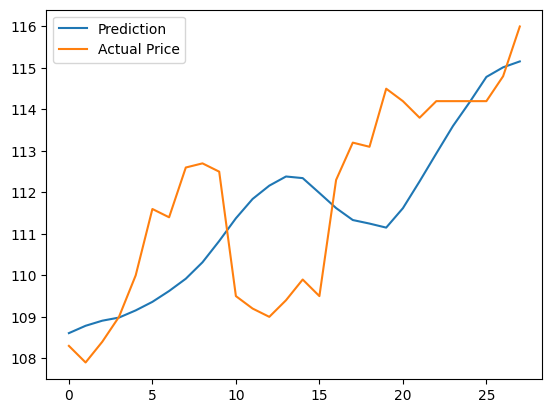

In [66]:
plt.plot(test_results['Test Predictions'],label='Prediction')
plt.plot(test_results['Actuals'],label='Actual Price')
plt.legend()
